### Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import warnings
import time
from time import time
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import math
import pickle
import statistics
import random
from sklearn.metrics.pairwise import cosine_similarity
from math import log
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sktime as sktime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sktime.datasets import load_from_tsfile_to_dataframe
from sktime.alignment.dtw_python import AlignerDTWfromDist
from sktime.dists_kernels.scipy_dist import ScipyDist
from sktime.dists_kernels.compose_from_align import DistFromAligner

### STEP-0: Preprocess the dataset

#### Convert MTS datasets into arrays and save them as pickle files for accessing later to measure DTWD distances

In [2]:
# Define a function to z-normalize a column
def z_normalize(column):
    mean = column.mean()
    std = column.std()
    z_normalized = (column - mean) / std
    return z_normalized

# Filter the DataFrame by numbers from the list
def filter_and_save_data(original_df, number_list):
    data_dict = {}
    for number in number_list:
        filtered_df = original_df[original_df['Subject']==number].reset_index()
        filtered_df = filtered_df.drop(columns=['Subject','index'])
        df_normalized = filtered_df.apply(z_normalize)
        data_dict[number] = np.array(df_normalized)
    return data_dict

#### Formulate a function to calculate DTWD distances between 2 MTS

In [ ]:
def dtwd_distance_calc(array1, array2):
    # multivariate euclidean distance between vectors
    eucl_dist = ScipyDist()
    # dtw-d alignment = DTW alignment using multivariate euclidean distance
    dtw_d_align = AlignerDTWfromDist(eucl_dist)
    # dtw-d distance between time series = distance matrix of the ddtw aligner
    dtw_d_dist = DistFromAligner(dtw_d_align)
    distance = dtw_d_dist(array1, array2)
    return distance 

#### Construct the final result matrix with DTWD distances recorded for various different time series

In [ ]:
def load_and_access_data(file_name,desired_number):
    with open(file_name, 'rb') as file:
        loaded_data_dict = pickle.load(file)
        desired_array = loaded_data_dict.get(desired_number)
    return desired_array

#### Form a DTW distance matrix

In [ ]:
def dtwd_dist_mat_form(number_list,pkl_filename):

    # Initialize result matrix
    result_matrix = np.zeros((len(number_list), len(number_list)))
    
    for i, number1 in enumerate(number_list):
        for j, number2 in enumerate(number_list):

            # Get stored arrays from the pickle file
            loaded_array_1 = load_and_access_data(pkl_filename,number1)
            loaded_array_2 = load_and_access_data(pkl_filename,number2)
            
            # Call dtwd_distance_calc function to calculate DTW distance
            distance = dtwd_distance_calc(loaded_array_1, loaded_array_2)
            display(f"Element [{i}, {j}] constructed. Progress: {i}/{len(number_list)} - {j}/{len(number_list)}")
            result_matrix[i, j] = distance
            
    result_df = pd.DataFrame(result_matrix, index=number_list, columns=number_list)
    return result_df

#### DTW distance calculation between sampled, and the other MTS from the healthy class

In [ ]:
def dtwd_dist_calc_rest(number_list,pkl_filename,current_index):
    
    dtwd_dist_list = []
    for number in (number_list):
        # Get stored arrays from the pickle file
        loaded_array_1 = load_and_access_data(pkl_filename,number)
        loaded_array_2 = load_and_access_data(pkl_filename,current_index)
        distance = dtwd_distance_calc(loaded_array_1, loaded_array_2)
        distance_value = distance[0, 0]
        dtwd_dist_list.append(distance_value)
    mean_dist = (statistics.mean(dtwd_dist_list)).tolist()
    return mean_dist

### STEP-1: Randomly sample subjects

In [ ]:
# Read dataframe from the pickle file
normal_df = pd.read_pickle('normal_public_sepsis.pkl')
# Display the loaded dataframe
display(normal_df.head())

In [ ]:
# Randomly sample MTS from the dataset based on Cochran's Sampling
n_unique_sub =  (normal_df['Subject']).nunique()
subjects_list = (normal_df['Subject']).unique()
num_random_numbers = 63
random_seed = 42
random.seed(random_seed)
random_subjects = random.sample(subjects_list.tolist(), num_random_numbers)

In [ ]:
# Check indices of the MTS which were not sampled with Cochran's sampling
rest_indices = [x for x in subjects_list if x not in random_subjects]

In [ ]:
# Build dataframe based on randomly chosen subjects
sample_df = normal_df[normal_df['Subject'].isin(random_subjects)] 

#### 1.1 Normalize MTS

In [ ]:
# Save arrays
original_df = normal_df
number_list = subjects_list
normalized_dict = filter_and_save_data(original_df, number_list)

In [ ]:
# Prepare the control DTW pickle file
file_name = 'normalized_df.pickle'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(normalized_dict, file)

In [ ]:
# Specify the path to your pickle file
pickle_file_path = 'normalized_df.pickle'

# Open the pickle file in binary mode (rb stands for read binary)
with open(pickle_file_path, 'rb') as file:
    # Load the data from the pickle file
    final_normal_df = pickle.load(file)

### STEP 2: Generate DTW Distance matrix from sampled MTS

In [ ]:
number_list = random_subjects
initial_DTW_matrix = dtwd_dist_mat_form(number_list,'normalized_df.pickle')

In [ ]:
# Save the DTWD distance matrix as a pkl file
initial_DTW_matrix.to_pickle("normal_DTW_matrix_sample.pkl")

In [ ]:
file_path = 'normal_DTW_matrix_sample.pkl'
# Read the pickle file into a DataFrame
initial_DTW_matrix = pd.read_pickle(file_path)

### STEP 3: Plot normal distribution

In [ ]:
normal_dtwd_dist = initial_DTW_matrix 
# Calculate the mean of each row and add a 'Mean' column
normal_dtwd_dist['Mean'] = normal_dtwd_dist.mean(axis=1)

In [ ]:
# Extract sample numbers, means, and calculate standard deviation
sample_numbers_normalized = normal_dtwd_dist.index
mean_normalized = normal_dtwd_dist['Mean']
mu_normalized = mean_normalized.mean()
std_dev_normalized = mean_normalized.std()

# Create a range of x values for the normal distribution curve
x_normalized = np.linspace(mu_normalized - 3 * std_dev_normalized, mu_normalized + 3 * std_dev_normalized, 100)

# Calculate the PDF values for the normal distribution
pdf_normalized = (1 / (std_dev_normalized * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_normalized - mu_normalized) / std_dev_normalized) ** 2)

# Create the plot, including the normal distribution and sample numbers
plt.figure(figsize=(10, 6))
plt.plot(x_normalized, pdf_normalized, label=f'Normal Distribution\nMean: {mu_normalized:.2f}, Std Dev: {std_dev_normalized:.2f}')
plt.scatter(mean_normalized, np.zeros_like(mean_normalized), label='Sample Numbers', color='red', marker='o')

# Add dotted vertical lines for the first and second standard deviations
plt.axvline(mu_normalized - std_dev_normalized, color='green', linestyle='--', label='1st Std Dev')
plt.axvline(mu_normalized + std_dev_normalized, color='green', linestyle='--', label='1st Std Dev')
plt.axvline(mu_normalized - 2 * std_dev_normalized, color='purple', linestyle='--', label='2nd Std Dev')
plt.axvline(mu_normalized + 2 * std_dev_normalized, color='purple', linestyle='--', label='2nd Std Dev')
plt.axvline(mu_normalized - 3 * std_dev_normalized, color='orange', linestyle='--', label='3rd Std Dev')
plt.axvline(mu_normalized + 3 * std_dev_normalized, color='orange', linestyle='--', label='3rd Std Dev')

for sample_number, mean_value in zip(sample_numbers_normalized, mean_normalized):
    plt.annotate(f'{sample_number}', (mean_value, 0), textcoords='offset points', xytext=(0, 10), ha='center')

plt.legend()
plt.title('Normal Distribution with Sample Numbers')
plt.xlabel('Value')
plt.ylabel('PDF')
plt.grid(True)
plt.show()

### STEP 4: Mark the indices of the MTS that lie within the 1st, 2nd, and 3rd standard deviations

In [ ]:
# Assuming you have the necessary variables defined (sample_numbers_normalized, mean_normalized, mu_normalized, std_dev_normalized)

# Define the range and step size for 'a' and 'b'
start_a = 0
end_a = 3.0
step_a = 0.1 
a_values = np.round(np.arange(start_a, end_a, step_a), 1).tolist()

start_b = 0.1
end_b = 3.1
step_b = 0.1 
b_values = np.round(np.arange(start_b, end_b, step_b), 1).tolist()

display(mu_normalized)
display(std_dev_normalized)

# Initialize a dictionary to store sample number lists with different names
sample_numbers_dict = {}

# Iterate over 'a' and 'b' values
for a, b in zip(a_values, b_values):
    # Generate a unique name for each pair
    name = f"sample_numbers_list_{round(a, 1)}_to_{round(b, 1)}"
    
    # Use list comprehension to filter sample numbers based on 'a' and 'b'
    sample_numbers_list = [sample for sample, mean in zip(sample_numbers_normalized, mean_normalized) if
                           mean >= mu_normalized - b * std_dev_normalized and mean <= mu_normalized - a * std_dev_normalized or
                           mean >= mu_normalized + a * std_dev_normalized and mean <= mu_normalized + b * std_dev_normalized]
    
    # Save the list to the dictionary with the unique name
    sample_numbers_dict[name] = sample_numbers_list

# Display sample numbers with different names
for name, sample_numbers_list in sample_numbers_dict.items():
    display(f"{name}:")
    display(sample_numbers_list)
    display()

In [ ]:
# Initialize an empty result dictionary
result_dict = {}

# Iterate through the first 10 keys
for key in list(sample_numbers_dict.keys())[:10]:
    # Access the list for each key
    display(key)
    number_list = sample_numbers_dict[key]

    # Determine the length of the list
    list_length = len(number_list)
    
    current_list = []
    for i in range(list_length):
        specific_value = number_list[i]
        display(specific_value)
        mean_value = normal_dtwd_dist.loc[specific_value,'Mean']
        display(mean_value)
        current_list.append(mean_value)
    display(current_list)
    max_value = max(current_list)
        
    # Form a new dictionary with the key and the corresponding 'mean' value
    result_dict[key] = max_value

# Print the resulting dictionary
display(result_dict)

### STEP 5: Evaluate rest of the MTS in the dataset to add them into the respective bins

In [ ]:
number_list = random_subjects
pkl_filename = 'normalized_df.pickle'
rest_distances_list = []
for rest_index in rest_indices:
    current_index = rest_index
    mean_dist_rest_index = dtwd_dist_calc_rest(number_list,pkl_filename,current_index)
    rest_distances_list.append(mean_dist_rest_index)

In [ ]:
df_windows = pd.DataFrame({'rest_distances_list':rest_distances_list,
              'rest_indices':rest_indices})
df_windows.head()

In [ ]:
# Prepare the control DTW pickle file
file_name = 'rest_distances_list.pickle'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(df_windows, file)

In [ ]:
start_a = 0
end_a = 3.0
step_a = 0.1 
a_values = np.round(np.arange(start_a, end_a, step_a), 1).tolist()

start_b = 0.1
end_b = 3.1
step_b = 0.1 
b_values = np.round(np.arange(start_b, end_b, step_b), 1).tolist()

# Initialize a dictionary to store sample number lists with different names
rest_numbers_dict = {}

# Iterate over 'a' and 'b' values
for a, b in zip(a_values, b_values):
    # Generate a unique name for each pair
    name = f"sample_numbers_list_{round(a, 1)}_to_{round(b, 1)}"
    
    # Use list comprehension to filter sample numbers based on 'a' and 'b'
    rest_numbers_list = [sample for sample, mean in zip(rest_indices, rest_distances_list) if
                           mean >= mu_normalized - b * std_dev_normalized and mean <= mu_normalized - a * std_dev_normalized or
                           mean >= mu_normalized + a * std_dev_normalized and mean <= mu_normalized + b * std_dev_normalized]
    
    # Save the list to the dictionary with the unique name
    rest_numbers_dict[name] = rest_numbers_list

# Display sample numbers with different names
for name, rest_numbers_list in rest_numbers_dict.items():
    display(f"{name}:")
    display(rest_numbers_list)
    display()

### STEP 6: Form the final dictionary combining the sampled and rest numbers

In [ ]:
final_dict = {key: sample_numbers_dict[key] + rest_numbers_dict[key] for key in sample_numbers_dict if key in rest_numbers_dict}
display(final_dict)

In [ ]:
# Prepare the control DTW pickle file
file_name = 'final_bins.pkl'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(final_dict, file)

## STEP 7: Finalize HBC employing classification with ROCKET classifier

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
from time import time
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
import statistics
import random
from sklearn.metrics.pairwise import cosine_similarity
from math import log
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sktime as sktime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.hybrid import HIVECOTEV2

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### 7.1 Load normal and abnormal datasets

In [4]:
final_normal_df = pd.read_pickle('normal_public_sepsis.pkl')
final_abnormal_df = pd.read_pickle('abnormal_public_sepsis.pkl')

In [5]:
abnormal_indices = (final_abnormal_df['Subject']).unique()
abnormal_no = (final_abnormal_df['Subject']).nunique()

175

In [6]:
# Specify the file path for final bins of the saved pkl file
file_path = 'final_bins.pkl'

# Load the dictionary from the pkl file
with open(file_path, 'rb') as file:
    final_numbers_dictionary = pickle.load(file)
display("Dictionary loaded from pickle file:")
display(final_numbers_dictionary)

'Dictionary loaded from pickle file:'

{'sample_numbers_list_0.0_to_0.1': [112,
  360,
  143,
  415,
  413,
  23,
  374,
  32,
  34,
  42,
  68,
  90,
  119,
  121,
  137,
  178,
  180,
  196,
  214,
  241,
  242,
  249,
  257,
  265,
  277,
  279,
  315,
  325,
  340,
  357,
  365,
  369,
  406,
  407,
  426,
  429,
  441,
  455,
  458,
  470,
  493],
 'sample_numbers_list_0.1_to_0.2': [14,
  288,
  20,
  33,
  35,
  51,
  52,
  60,
  63,
  67,
  73,
  144,
  167,
  176,
  205,
  228,
  235,
  250,
  296,
  313,
  323,
  337,
  362,
  396,
  409,
  419,
  440,
  464,
  467,
  486,
  489],
 'sample_numbers_list_0.2_to_0.3': [378,
  280,
  50,
  3,
  5,
  41,
  43,
  70,
  117,
  123,
  139,
  164,
  220,
  225,
  244,
  247,
  262,
  289,
  320,
  334,
  344,
  350,
  363,
  381,
  393,
  394,
  417,
  444,
  474,
  480,
  487,
  496],
 'sample_numbers_list_0.3_to_0.4': [72,
  457,
  7,
  27,
  30,
  69,
  79,
  100,
  138,
  150,
  160,
  163,
  204,
  232,
  245,
  300,
  331,
  336,
  341,
  352,
  377,
  402,
  408,
  4

In [7]:
dictionary_keys = final_numbers_dictionary.keys()
keys_list = list(dictionary_keys)
keys_list

['sample_numbers_list_0.0_to_0.1',
 'sample_numbers_list_0.1_to_0.2',
 'sample_numbers_list_0.2_to_0.3',
 'sample_numbers_list_0.3_to_0.4',
 'sample_numbers_list_0.4_to_0.5',
 'sample_numbers_list_0.5_to_0.6',
 'sample_numbers_list_0.6_to_0.7',
 'sample_numbers_list_0.7_to_0.8',
 'sample_numbers_list_0.8_to_0.9',
 'sample_numbers_list_0.9_to_1.0',
 'sample_numbers_list_1.0_to_1.1',
 'sample_numbers_list_1.1_to_1.2',
 'sample_numbers_list_1.2_to_1.3',
 'sample_numbers_list_1.3_to_1.4',
 'sample_numbers_list_1.4_to_1.5',
 'sample_numbers_list_1.5_to_1.6',
 'sample_numbers_list_1.6_to_1.7',
 'sample_numbers_list_1.7_to_1.8',
 'sample_numbers_list_1.8_to_1.9',
 'sample_numbers_list_1.9_to_2.0',
 'sample_numbers_list_2.0_to_2.1',
 'sample_numbers_list_2.1_to_2.2',
 'sample_numbers_list_2.2_to_2.3',
 'sample_numbers_list_2.3_to_2.4',
 'sample_numbers_list_2.4_to_2.5',
 'sample_numbers_list_2.5_to_2.6',
 'sample_numbers_list_2.6_to_2.7',
 'sample_numbers_list_2.7_to_2.8',
 'sample_numbers_lis

### 7.2 Function to find the length of the time series (Contains the list of functions to adjust the time series lengths for classification)

In [8]:
def time_series_length_finding(df):
    train_1_abnormal = df.copy()
    train_1_ab_sub = (train_1_abnormal['Subject'].unique()).tolist()
    row_count = []
    for i in train_1_ab_sub:
        train_1_abnormal_new = train_1_abnormal[(train_1_abnormal['Subject']== i)]
        no_rows = train_1_abnormal_new.shape[0]
        row_count.append(no_rows)
    display("Avg length:",statistics.mean(row_count))
    avg_len_ts = int(statistics.mean(row_count))
    return(avg_len_ts)

In [11]:
def preprocessing_normal_df(df,desired_length):
    train_2_normal = df.copy()
    df_train_3 = pd.DataFrame(columns = train_2_normal.columns)
    num_dim = df_train_3.shape[1]
    display(num_dim)
    df_train_3.columns = range(len(df_train_3.columns))
    train_2_sub = (train_2_normal['Subject'].unique()).tolist()
    m = 0
    for i in train_2_sub:
        train_2_normal_new = train_2_normal[(train_2_normal['Subject']== i)]
        df_row_count = train_2_normal_new.shape[0]
        if df_row_count < desired_length:
            rows_to_add = desired_length - df_row_count
            train_2_normal_new.tail()
            last_row = train_2_normal_new.ffill().iloc[[-1]]  # Extract the last row
            new_rows_df = pd.concat([last_row] * rows_to_add, ignore_index=True)
            train_2_normal_initial = pd.concat([train_2_normal_new, new_rows_df], ignore_index=True)
            train_2_normal_initial_no_sub = train_2_normal_initial.drop(columns='Subject')
            train_2_normal_final = z_normalize(train_2_normal_initial_no_sub)
            train_2_normal_final.insert(0, 'Subject', i)

        else:
            train_2_normal_initial = train_2_normal_new.iloc[:desired_length,:]
            train_2_normal_initial_no_sub = train_2_normal_initial.drop(columns='Subject')
            train_2_normal_final = z_normalize(train_2_normal_initial_no_sub)
            train_2_normal_final.insert(0, 'Subject', i)
            
        train_2_normal_final.columns = range(len(train_2_normal_final.columns))
        
        df_train_3.at[m,0] = i
        j = 0
        while j < num_dim:
            df_train_3.at[m,j] = train_2_normal_final[j]
            j += 1
        m += 1    
    df_train_3['class'] = 'normal'
    df_normal_baseline = df_train_3.iloc[:,1:]
    return(df_normal_baseline)

In [12]:
def preprocessing_dataframe(df,desired_length):
    train_1_abnormal = df.copy()
    df_train_2 = pd.DataFrame(columns = train_1_abnormal.columns)
    num_dim_ab = df_train_2.shape[1]
    df_train_2.columns = range(len(df_train_2.columns))
    train_1_ab_sub = (train_1_abnormal['Subject'].unique()).tolist()
    m = 0
    for i in train_1_ab_sub:
        train_1_abnormal_new = train_1_abnormal[(train_1_abnormal['Subject']== i)]
        df_row_count = train_1_abnormal_new.shape[0]
        if df_row_count < desired_length:
            rows_to_add = desired_length - df_row_count
            last_row = train_1_abnormal_new.ffill().iloc[[-1]]  # Extract the last row
            new_rows_df = pd.concat([last_row] * rows_to_add, ignore_index=True)
            train_1_abnormal_initial = pd.concat([train_1_abnormal_new, new_rows_df], ignore_index=True)
            train_1_abnormal_initial_no_sub = train_1_abnormal_initial.drop(columns='Subject')
            train_1_abnormal_final = z_normalize(train_1_abnormal_initial_no_sub)
            train_1_abnormal_final.insert(0, 'Subject', i)
        else:
            train_1_abnormal_initial = train_1_abnormal_new.iloc[:desired_length,:]
            train_1_abnormal_initial_no_sub = train_1_abnormal_initial.drop(columns='Subject')
            train_1_abnormal_final = z_normalize(train_1_abnormal_initial_no_sub)
            train_1_abnormal_final.insert(0, 'Subject', i)
        train_1_abnormal_final.columns = range(len(train_1_abnormal_final.columns))
        df_train_2.at[m,0] = i
        j = 0
        while j < num_dim_ab:
            df_train_2.at[m,j] = train_1_abnormal_final[j]
            j += 1
        m += 1    
    df_train_2['class'] = 'abnormal'
    df_final = df_train_2.iloc[:,1:]
    return(df_final)

### 7.3 Perform classification with ROCKET classifier

In [13]:
def ts_classifier(df_class_1):
    accuacy_list_1 = []
    precision_list_1 = []
    recall_list_1 = []
    f1_list_1 = []

    X_1 = df_class_1.iloc[:,:-1]
    y_1 = df_class_1.iloc[:,-1]
    
    display("X_1:",X_1)

    for i in range(1,31):
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=i,stratify = y_1)

        rocket = Rocket(num_kernels=10000)
        rocket.fit(X_train_1)
        X_train_transform_1 = rocket.transform(X_train_1)
        classifier_1 = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
        classifier_1.fit(X_train_transform_1, y_train_1)
        X_test_transform_1 = rocket.transform(X_test_1)
        y_pred_1 = classifier_1.predict(X_test_transform_1)

        pos_label = 'abnormal'

        acc_1 = accuracy_score(y_test_1, y_pred_1)
        accuacy_list_1.append(acc_1)

        prec_1 = precision_score(y_test_1, y_pred_1, pos_label=pos_label)
        precision_list_1.append(prec_1)

        recall_1 = recall_score(y_test_1, y_pred_1, pos_label=pos_label)
        recall_list_1.append(recall_1)

        f1_1 = f1_score(y_test_1, y_pred_1, pos_label=pos_label)
        f1_list_1.append(f1_1)
        
        display("Completed",i)

    acc_mean_1 = np.mean(accuacy_list_1)
    acc_std_dev_1 = np.std(accuacy_list_1)

    prec_mean_1 = np.mean(precision_list_1)
    prec_std_dev_1 = np.std(precision_list_1)

    recall_mean_1 = np.mean(recall_list_1)
    recall_std_dev_1 = np.std(recall_list_1)

    f1_mean_1 = np.mean(f1_list_1)
    f1_std_dev_1 = np.std(f1_list_1)

    return(acc_mean_1,acc_std_dev_1,prec_mean_1,prec_std_dev_1,recall_mean_1,recall_std_dev_1,f1_mean_1,f1_std_dev_1)

In [14]:
classifier_dict = {}
normal_sample_numbers = [] 
for key in keys_list:
    display("Current key in progress",key)

    if not final_numbers_dictionary[key]:
        display("Moving on to the next key")
        continue

    normal_sample_numbers.extend(final_numbers_dictionary[key])
    normal_sample_length = len(normal_sample_numbers)
    display(normal_sample_length)

    if len(normal_sample_numbers) <= abnormal_no:
        df_normal = final_normal_df[final_normal_df['Subject'].isin(normal_sample_numbers)]
        display(df_normal)

        random.seed(42)
        abnormal_sample_numbers = random.sample(abnormal_indices.tolist(), normal_sample_length)
        df_abnormal = final_abnormal_df[final_abnormal_df['Subject'].isin(abnormal_sample_numbers)]
        display(df_abnormal)

        desired_length_for_ts = time_series_length_finding(df_abnormal)

        df_normal_preprocessed = preprocessing_normal_df(df_normal,desired_length_for_ts)
        df_abnormal_preprocessed = preprocessing_dataframe(df_abnormal,desired_length_for_ts)

        df_classifier = (pd.concat([df_normal_preprocessed,df_abnormal_preprocessed]).reset_index()).drop(columns='index')
        acc_mean,acc_std_dev,prec_mean,prec_std_dev,recall_mean,recall_std_dev,f1_mean,f1_std_dev = ts_classifier(df_classifier)

        classifier_dict[key] = {'acc_mean': acc_mean,'acc_std_dev': acc_std_dev,'prec_mean': prec_mean,'prec_std_dev': prec_std_dev,'recall_mean': recall_mean,'recall_std_dev': recall_std_dev,'f1_mean': f1_mean,'f1_std_dev': f1_std_dev}

    else:
        df_abnormal = final_abnormal_df

        random.seed(42)
        random_sample_numbers = random.sample(normal_sample_numbers, abnormal_no)
        df_normal = final_normal_df[final_normal_df['Subject'].isin(random_sample_numbers)]
        display(df_normal)

        desired_length_for_ts = time_series_length_finding(df_abnormal)

        df_normal_preprocessed = preprocessing_normal_df(df_normal,desired_length_for_ts)
        df_abnormal_preprocessed = preprocessing_dataframe(df_abnormal,desired_length_for_ts)

        df_classifier = (pd.concat([df_normal_preprocessed,df_abnormal_preprocessed]).reset_index()).drop(columns='index')
        acc_mean,acc_std_dev,prec_mean,prec_std_dev,recall_mean,recall_std_dev,f1_mean,f1_std_dev = ts_classifier(df_classifier)

        classifier_dict[key] = {'acc_mean': acc_mean,'acc_std_dev': acc_std_dev,'prec_mean': prec_mean,'prec_std_dev': prec_std_dev,'recall_mean': recall_mean,'recall_std_dev': recall_std_dev,'f1_mean': f1_mean,'f1_std_dev': f1_std_dev}

'Current key in progress'

'sample_numbers_list_0.0_to_0.1'

41

,Subject,HR,MAP,DBP,SBP,Resp
0,23,96.0,62.5,52.0,86.0,15.0
1,23,98.0,67.0,52.0,91.0,17.0
2,23,94.5,67.5,53.0,96.0,18.0
3,23,72.0,70.0,53.0,105.0,16.0
4,23,82.0,79.0,59.0,118.0,16.0
...,...,...,...,...,...,...
48,493,102.0,109.0,86.0,150.0,23.0
49,493,87.0,104.0,80.0,149.0,23.0
50,493,105.0,99.0,75.0,155.0,20.0
51,493,80.0,107.0,85.0,149.0,20.0


,Subject,HR,MAP,DBP,SBP,Resp
0,2,77.0,102.0,74.0,161.0,18.5
1,2,78.0,102.0,74.0,129.0,18.0
2,2,74.0,102.0,74.0,144.5,20.0
3,2,77.0,103.0,78.0,150.5,18.0
4,2,78.0,99.0,80.0,134.0,18.0
...,...,...,...,...,...,...
121,175,109.0,100.0,65.0,94.0,31.0
122,175,99.0,77.0,65.0,94.0,16.0
123,175,113.0,105.0,65.0,94.0,21.0
124,175,110.0,105.0,65.0,94.0,18.0


'Avg length:'

101.4390243902439

6

'X_1:'

,1,2,3,4,5
0,0 -0.394469 1 -0.292115 2 -0.47123...,0 -0.049971 1 0.478211 2 0.53689...,0 0.579107 1 0.579107 2 0.73122...,0 -0.689118 1 -0.352719 2 -0.01632...,0 0.095762 1 0.618569 2 0.87997...
1,0 3.102583 1 2.613911 2 2.85824...,0 1.698444 1 1.761721 2 1.63516...,0 0.614736 1 0.980607 2 2.51726...,0 1.450056 1 1.512644 2 1.32488...,0 0.378916 1 1.841482 2 -2.05869...
2,0 -0.873973 1 -0.873973 2 -0.68774...,0 -0.611484 1 -0.611484 2 -0.28614...,0 -1.066474 1 -1.066474 2 -0.78038...,0 -1.312973 1 -1.312973 2 -1.31297...,0 1.008233 1 1.008233 2 -0.43875...
3,0 -0.965339 1 -0.965339 2 -0.31822...,0 -0.995545 1 -0.995545 2 -0.99554...,0 -0.976050 1 -0.976050 2 -0.97605...,0 -0.053530 1 -0.053530 2 -0.05353...,0 -2.462892 1 -2.462892 2 -1.53902...
4,0 0.944264 1 0.944264 2 0.03793...,0 -1.406446 1 -1.406446 2 -1.67748...,0 -0.616385 1 -0.616385 2 -1.85671...,0 -0.695759 1 -0.695759 2 -1.88092...,0 0.707579 1 0.707579 2 -0.22865...
...,...,...,...,...,...
77,0 1.285348 1 0.450827 2 -0.01859...,0 -0.183241 1 -1.024484 2 -0.52963...,0 0.852060 1 0.852060 2 0.85206...,0 1.551553 1 1.551553 2 1.55155...,0 -0.973400 1 -0.658797 2 -0.34419...
78,0 1.538460 1 0.668500 2 1.63512...,0 -0.215327 1 0.127162 2 -0.62631...,0 0.704699 1 0.544636 2 0.59799...,0 -0.704318 1 -0.240334 2 -0.16707...,0 -0.478851 1 -0.478851 2 -0.47885...
79,0 -0.714646 1 -0.739256 2 -0.96074...,0 -0.575362 1 -0.626248 2 -0.42270...,0 -0.338767 1 -0.409024 2 -0.83057...,0 -0.439534 1 -0.492541 2 0.01102...,0 -0.526410 1 -0.526410 2 -0.16015...
80,0 -1.036691 1 -0.880134 2 -0.53570...,0 -0.735505 1 -0.687236 2 -0.68723...,0 -1.000854 1 -0.556937 2 -0.62035...,0 -0.407698 1 -0.570326 2 -0.63537...,0 -2.282138 1 -2.282138 2 -2.28213...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.1_to_0.2'

72

,Subject,HR,MAP,DBP,SBP,Resp
0,14,58.0,71.5,49.0,123.5,11.0
1,14,75.0,80.0,58.0,136.0,12.0
2,14,75.0,80.0,58.0,136.0,12.0
3,14,75.0,80.0,58.0,136.0,12.0
4,14,76.5,82.0,62.0,137.0,16.5
...,...,...,...,...,...,...
48,493,102.0,109.0,86.0,150.0,23.0
49,493,87.0,104.0,80.0,149.0,23.0
50,493,105.0,99.0,75.0,155.0,20.0
51,493,80.0,107.0,85.0,149.0,20.0


,Subject,HR,MAP,DBP,SBP,Resp
0,2,77.0,102.0,74.0,161.0,18.5
1,2,78.0,102.0,74.0,129.0,18.0
2,2,74.0,102.0,74.0,144.5,20.0
3,2,77.0,103.0,78.0,150.5,18.0
4,2,78.0,99.0,80.0,134.0,18.0
...,...,...,...,...,...,...
121,175,109.0,100.0,65.0,94.0,31.0
122,175,99.0,77.0,65.0,94.0,16.0
123,175,113.0,105.0,65.0,94.0,21.0
124,175,110.0,105.0,65.0,94.0,18.0


'Avg length:'

106.48611111111111

6

'X_1:'

,1,2,3,4,5
0,0 -0.105458 1 2.156868 2 2.15686...,0 -2.226819 1 -1.046605 2 -1.04660...,0 -2.899032 1 -1.326285 2 -1.32628...,0 -1.365259 1 -0.350125 2 -0.35012...,0 -0.542939 1 -0.029086 2 -0.02908...
1,0 -1.086132 1 -1.086132 2 -0.87655...,0 -0.727819 1 -0.727819 2 -0.98801...,0 -1.194132 1 -1.194132 2 -1.26061...,0 -0.746295 1 -0.746295 2 -1.41598...,0 -0.656451 1 -0.656451 2 -1.44081...
2,0 -0.441790 1 -0.339262 2 -0.51868...,0 -0.011731 1 0.521171 2 0.58038...,0 0.622406 1 0.622406 2 0.77601...,0 -0.660632 1 -0.320530 2 0.01957...,0 0.129944 1 0.659714 2 0.92459...
3,0 3.186905 1 2.687368 2 2.93713...,0 1.754275 1 1.818485 2 1.69006...,0 0.656200 1 1.026776 2 2.58319...,0 1.502163 1 1.565475 2 1.37553...,0 0.393412 1 1.891676 2 -2.10369...
4,0 -0.866961 1 -1.463458 2 -1.76170...,0 6.174958 1 0.460671 2 -0.42986...,0 5.486180 1 0.092835 2 -0.85336...,0 5.608109 1 -0.055790 2 -0.83318...,0 -3.297001 1 -2.740146 2 -1.51506...
...,...,...,...,...,...
139,0 1.511999 1 0.639111 2 1.60898...,0 -0.257419 1 0.084088 2 -0.66722...,0 0.658101 1 0.498956 2 0.55200...,0 -0.746631 1 -0.281084 2 -0.20757...,0 -0.484875 1 -0.484875 2 -0.48487...
140,0 -0.709804 1 -0.734702 2 -0.95877...,0 -0.604892 1 -0.653614 2 -0.45872...,0 -0.371030 1 -0.439191 2 -0.84816...,0 -0.476280 1 -0.528034 2 -0.03637...,0 -0.543197 1 -0.543197 2 -0.17449...
141,0 -0.593188 1 -0.482973 2 -0.81362...,0 1.633853 1 -0.252631 2 -1.40292...,0 0.101221 1 -0.700402 2 -1.62535...,0 2.711120 1 -0.052762 2 -1.19083...,0 -2.354645 1 0.265747 2 0.26574...
142,0 -0.891320 1 -0.743649 2 -0.41877...,0 -0.722405 1 -0.673287 2 -0.67328...,0 -0.948864 1 -0.505782 2 -0.56908...,0 -0.415329 1 -0.581964 2 -0.64861...,0 -2.125695 1 -2.125695 2 -2.12569...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.2_to_0.3'

104

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
50,496,94.0,94.0,75.0,141.0,20.0
51,496,87.0,100.0,80.0,159.0,18.0
52,496,89.0,96.0,80.0,159.0,19.0
53,496,87.0,71.0,80.0,159.0,20.0


,Subject,HR,MAP,DBP,SBP,Resp
0,2,77.0,102.0,74.0,161.0,18.5
1,2,78.0,102.0,74.0,129.0,18.0
2,2,74.0,102.0,74.0,144.5,20.0
3,2,77.0,103.0,78.0,150.5,18.0
4,2,78.0,99.0,80.0,134.0,18.0
...,...,...,...,...,...,...
121,175,109.0,100.0,65.0,94.0,31.0
122,175,99.0,77.0,65.0,94.0,16.0
123,175,113.0,105.0,65.0,94.0,21.0
124,175,110.0,105.0,65.0,94.0,18.0


'Avg length:'

109.23076923076923

6

'X_1:'

,1,2,3,4,5
0,0 -3.564786 1 -3.383258 2 -1.93103...,0 0.433371 1 1.501554 2 2.56973...,0 0.731196 1 1.502490 2 2.53088...,0 -1.552157 1 0.212080 2 0.26396...,0 -3.942636 1 -4.143077 2 -1.13645...
1,0 -0.145482 1 -1.677179 2 -1.04648...,0 4.969324 1 2.082431 2 -1.59179...,0 3.533118 1 1.442024 2 -2.04313...,0 4.291319 1 2.656595 2 -0.86053...,0 -2.489027 1 -0.784053 2 1.34716...
2,0 -0.092539 1 2.193802 2 2.19380...,0 -2.263661 1 -1.073038 2 -1.07303...,0 -2.944664 1 -1.353523 2 -1.35352...,0 -1.394522 1 -0.370520 2 -0.37052...,0 -0.533305 1 -0.014285 2 -0.01428...
3,0 -1.091143 1 -1.091143 2 -0.87888...,0 -0.742902 1 -0.742902 2 -1.00666...,0 -1.221730 1 -1.221730 2 -1.28881...,0 -0.768335 1 -0.768335 2 -1.44509...,0 -0.647905 1 -0.647905 2 -1.44013...
4,0 -0.468615 1 -0.365892 2 -0.54565...,0 0.009834 1 0.545767 2 0.60531...,0 0.647277 1 0.647277 2 0.80182...,0 -0.644925 1 -0.302515 2 0.03989...,0 0.149427 1 0.683444 2 0.95045...
...,...,...,...,...,...
203,0 -0.704896 1 -0.729858 2 -0.95451...,0 -0.605291 1 -0.652825 2 -0.46269...,0 -0.368696 1 -0.436467 2 -0.84309...,0 -0.483563 1 -0.534026 2 -0.05462...,0 -0.541624 1 -0.541624 2 -0.16836...
204,0 -0.617524 1 -0.506726 2 -0.83912...,0 1.634187 1 -0.269666 2 -1.43055...,0 0.084377 1 -0.723475 2 -1.65561...,0 2.734129 1 -0.061865 2 -1.21315...,0 -2.389667 1 0.263715 2 0.26371...
205,0 -0.821041 1 -0.677254 2 -0.36092...,0 -0.715229 1 -0.665604 2 -0.66560...,0 -0.921054 1 -0.477949 2 -0.54125...,0 -0.419846 1 -0.588839 2 -0.65643...,0 -2.049411 1 -2.049411 2 -2.04941...
206,0 2.117714 1 0.853176 2 1.48544...,0 -0.741608 1 -1.691784 2 -1.44544...,0 -1.122280 1 -2.152415 2 -1.29396...,0 0.176176 1 -2.340106 2 -2.14145...,0 -0.052018 1 -0.052018 2 0.19450...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.3_to_0.4'

130

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
50,500,67.0,69.0,50.0,121.0,17.0
51,500,66.0,66.0,48.0,112.0,20.0
52,500,69.0,78.0,57.0,126.0,19.0
53,500,66.0,67.0,49.0,114.0,18.0


,Subject,HR,MAP,DBP,SBP,Resp
0,2,77.0,102.0,74.0,161.0,18.5
1,2,78.0,102.0,74.0,129.0,18.0
2,2,74.0,102.0,74.0,144.5,20.0
3,2,77.0,103.0,78.0,150.5,18.0
4,2,78.0,99.0,80.0,134.0,18.0
...,...,...,...,...,...,...
121,175,109.0,100.0,65.0,94.0,31.0
122,175,99.0,77.0,65.0,94.0,16.0
123,175,113.0,105.0,65.0,94.0,21.0
124,175,110.0,105.0,65.0,94.0,18.0


'Avg length:'

109.46923076923076

6

'X_1:'

,1,2,3,4,5
0,0 -3.564786 1 -3.383258 2 -1.93103...,0 0.433371 1 1.501554 2 2.56973...,0 0.731196 1 1.502490 2 2.53088...,0 -1.552157 1 0.212080 2 0.26396...,0 -3.942636 1 -4.143077 2 -1.13645...
1,0 -0.145482 1 -1.677179 2 -1.04648...,0 4.969324 1 2.082431 2 -1.59179...,0 3.533118 1 1.442024 2 -2.04313...,0 4.291319 1 2.656595 2 -0.86053...,0 -2.489027 1 -0.784053 2 1.34716...
2,0 -2.721065 1 -2.773532 2 -2.30132...,0 -0.656820 1 -0.656820 2 0.83160...,0 -0.871510 1 -0.871510 2 0.97304...,0 -1.256947 1 -1.256947 2 1.62868...,0 -1.472858 1 -1.472858 2 -1.47285...
3,0 -0.092539 1 2.193802 2 2.19380...,0 -2.263661 1 -1.073038 2 -1.07303...,0 -2.944664 1 -1.353523 2 -1.35352...,0 -1.394522 1 -0.370520 2 -0.37052...,0 -0.533305 1 -0.014285 2 -0.01428...
4,0 -1.091143 1 -1.091143 2 -0.87888...,0 -0.742902 1 -0.742902 2 -1.00666...,0 -1.221730 1 -1.221730 2 -1.28881...,0 -0.768335 1 -0.768335 2 -1.44509...,0 -0.647905 1 -0.647905 2 -1.44013...
...,...,...,...,...,...
255,0 0.642459 1 0.582038 2 -0.44512...,0 0.617474 1 1.599373 2 1.42084...,0 3.285655 1 3.285655 2 1.58832...,0 0.693578 1 0.693578 2 -0.02642...,0 -0.469010 1 0.538322 2 -0.46901...
256,0 0.046939 1 0.046939 2 0.74918...,0 -0.056599 1 -0.056599 2 -0.05659...,0 0.216338 1 0.216338 2 -0.04787...,0 -0.452964 1 -0.452964 2 -0.13596...,0 -0.488404 1 -0.488404 2 -1.35845...
257,0 -0.821041 1 -0.677254 2 -0.36092...,0 -0.715229 1 -0.665604 2 -0.66560...,0 -0.921054 1 -0.477949 2 -0.54125...,0 -0.419846 1 -0.588839 2 -0.65643...,0 -2.049411 1 -2.049411 2 -2.04941...
258,0 2.117714 1 0.853176 2 1.48544...,0 -0.741608 1 -1.691784 2 -1.44544...,0 -1.122280 1 -2.152415 2 -1.29396...,0 0.176176 1 -2.340106 2 -2.14145...,0 -0.052018 1 -0.052018 2 0.19450...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.4_to_0.5'

169

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
50,500,67.0,69.0,50.0,121.0,17.0
51,500,66.0,66.0,48.0,112.0,20.0
52,500,69.0,78.0,57.0,126.0,19.0
53,500,66.0,67.0,49.0,114.0,18.0


,Subject,HR,MAP,DBP,SBP,Resp
0,1,103.0,80.0,64.0,112.0,20.0
1,1,111.0,93.5,80.5,131.0,20.0
2,1,106.0,87.0,77.0,114.0,20.0
3,1,107.0,62.0,54.0,85.0,20.0
4,1,106.0,80.0,70.0,109.0,23.0
...,...,...,...,...,...,...
121,175,109.0,100.0,65.0,94.0,31.0
122,175,99.0,77.0,65.0,94.0,16.0
123,175,113.0,105.0,65.0,94.0,21.0
124,175,110.0,105.0,65.0,94.0,18.0


'Avg length:'

107.29585798816568

6

'X_1:'

,1,2,3,4,5
0,0 -3.532758 1 -3.352283 2 -1.90848...,0 0.428580 1 1.486844 2 2.54510...,0 0.715312 1 1.482400 2 2.50518...,0 -1.531798 1 0.222548 2 0.27414...,0 -3.905355 1 -4.104342 2 -1.11953...
1,0 -0.145159 1 -1.662650 2 -1.03780...,0 4.924285 1 2.058658 2 -1.58850...,0 3.499770 1 1.422557 2 -2.03946...,0 4.255151 1 2.629867 2 -0.86695...,0 -2.464715 1 -0.775527 2 1.33595...
2,0 1.017120 1 1.017120 2 0.93308...,0 1.466091 1 1.466091 2 0.00341...,0 0.196592 1 0.196592 2 -0.91639...,0 2.282684 1 2.282684 2 0.77855...,0 1.239447 1 1.239447 2 3.52820...
3,0 -2.712193 1 -2.764304 2 -2.29530...,0 -0.642553 1 -0.642553 2 0.83601...,0 -0.857057 1 -0.857057 2 0.97338...,0 -1.238628 1 -1.238628 2 1.62824...,0 -1.458492 1 -1.458492 2 -1.45849...
4,0 -0.101098 1 2.169249 2 2.16924...,0 -2.239165 1 -1.055485 2 -1.05548...,0 -2.914322 1 -1.335423 2 -1.33542...,0 -1.375081 1 -0.356996 2 -0.35699...,0 -0.539670 1 -0.024092 2 -0.02409...
...,...,...,...,...,...
333,0 0.657722 1 0.597417 2 -0.42777...,0 0.599663 1 1.579946 2 1.40171...,0 3.273461 1 3.273461 2 1.58749...,0 0.689393 1 0.689393 2 -0.02400...,0 -0.455927 1 0.544774 2 -0.45592...
334,0 0.044599 1 0.044599 2 0.74052...,0 -0.073953 1 -0.073953 2 -0.07395...,0 0.211057 1 0.211057 2 -0.05077...,0 -0.448563 1 -0.448563 2 -0.13409...,0 -0.468329 1 -0.468329 2 -1.34651...
335,0 -0.866741 1 -0.720461 2 -0.39864...,0 -0.719960 1 -0.670672 2 -0.67067...,0 -0.939339 1 -0.496288 2 -0.55958...,0 -0.416840 1 -0.584264 2 -0.65123...,0 -2.099028 1 -2.099028 2 -2.09902...
336,0 2.311233 1 0.962620 2 1.63692...,0 -0.728086 1 -1.673453 2 -1.42835...,0 -1.115160 1 -2.164146 2 -1.28999...,0 0.187708 1 -2.339507 2 -2.13999...,0 -0.046224 1 -0.046224 2 0.20107...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.5_to_0.6'

202

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
50,500,67.0,69.0,50.0,121.0,17.0
51,500,66.0,66.0,48.0,112.0,20.0
52,500,69.0,78.0,57.0,126.0,19.0
53,500,66.0,67.0,49.0,114.0,18.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -5.247498 1 -3.216591 2 -1.07879...,0 -1.347462 1 -2.628016 2 -0.79865...,0 -1.027504 1 -1.688042 2 -0.08387...,0 -1.546311 1 -2.554553 2 -1.50048...,0 -2.900664 1 -2.496312 2 -1.58652...
2,0 1.025971 1 1.025971 2 0.94170...,0 1.474437 1 1.474437 2 0.00510...,0 0.195653 1 0.195653 2 -0.92236...,0 2.295130 1 2.295130 2 0.78441...,0 1.248605 1 1.248605 2 3.54499...
3,0 -2.716608 1 -2.768897 2 -2.29829...,0 -0.649718 1 -0.649718 2 0.83378...,0 -0.864310 1 -0.864310 2 0.97319...,0 -1.247820 1 -1.247820 2 1.62843...,0 -1.465692 1 -1.465692 2 -1.46569...
4,0 1.375152 1 1.375152 2 -4.37386...,0 -0.129986 1 -0.129986 2 0.52296...,0 0.674782 1 0.674782 2 0.44488...,0 -0.329309 1 -0.329309 2 1.36877...,0 1.599053 1 1.599053 2 1.18884...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.6_to_0.7'

237

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
2,0 1.025971 1 1.025971 2 0.94170...,0 1.474437 1 1.474437 2 0.00510...,0 0.195653 1 0.195653 2 -0.92236...,0 2.295130 1 2.295130 2 0.78441...,0 1.248605 1 1.248605 2 3.54499...
3,0 1.375152 1 1.375152 2 -4.37386...,0 -0.129986 1 -0.129986 2 0.52296...,0 0.674782 1 0.674782 2 0.44488...,0 -0.329309 1 -0.329309 2 1.36877...,0 1.599053 1 1.599053 2 1.18884...
4,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.7_to_0.8'

264

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
2,0 1.375152 1 1.375152 2 -4.37386...,0 -0.129986 1 -0.129986 2 0.52296...,0 0.674782 1 0.674782 2 0.44488...,0 -0.329309 1 -0.329309 2 1.36877...,0 1.599053 1 1.599053 2 1.18884...
3,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
4,0 -0.096793 1 2.181560 2 2.18156...,0 -2.251445 1 -1.064296 2 -1.06429...,0 -2.929532 1 -1.344503 2 -1.34450...,0 -1.384835 1 -0.363793 2 -0.36379...,0 -0.536459 1 -0.019159 2 -0.01915...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.8_to_0.9'

286

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.00,50.0,97.00,12.0
1,3,90.0,71.50,54.5,114.00,11.5
2,3,98.0,76.00,60.5,114.50,19.0
3,3,108.0,72.00,59.5,102.50,19.0
4,3,111.0,72.00,61.0,100.00,18.0
...,...,...,...,...,...,...
46,507,80.0,92.33,75.0,164.50,15.0
47,507,76.0,84.33,68.0,148.50,18.0
48,507,138.0,96.67,83.5,156.50,17.0
49,507,111.0,97.33,81.0,152.00,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -5.247498 1 -3.216591 2 -1.07879...,0 -1.347462 1 -2.628016 2 -0.79865...,0 -1.027504 1 -1.688042 2 -0.08387...,0 -1.546311 1 -2.554553 2 -1.50048...,0 -2.900664 1 -2.496312 2 -1.58652...
2,0 1.025971 1 1.025971 2 0.94170...,0 1.474437 1 1.474437 2 0.00510...,0 0.195653 1 0.195653 2 -0.92236...,0 2.295130 1 2.295130 2 0.78441...,0 1.248605 1 1.248605 2 3.54499...
3,0 1.375152 1 1.375152 2 -4.37386...,0 -0.129986 1 -0.129986 2 0.52296...,0 0.674782 1 0.674782 2 0.44488...,0 -0.329309 1 -0.329309 2 1.36877...,0 1.599053 1 1.599053 2 1.18884...
4,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.9_to_1.0'

324

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.00,50.0,97.00,12.0
1,3,90.0,71.50,54.5,114.00,11.5
2,3,98.0,76.00,60.5,114.50,19.0
3,3,108.0,72.00,59.5,102.50,19.0
4,3,111.0,72.00,61.0,100.00,18.0
...,...,...,...,...,...,...
46,507,80.0,92.33,75.0,164.50,15.0
47,507,76.0,84.33,68.0,148.50,18.0
48,507,138.0,96.67,83.5,156.50,17.0
49,507,111.0,97.33,81.0,152.00,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -5.247498 1 -3.216591 2 -1.07879...,0 -1.347462 1 -2.628016 2 -0.79865...,0 -1.027504 1 -1.688042 2 -0.08387...,0 -1.546311 1 -2.554553 2 -1.50048...,0 -2.900664 1 -2.496312 2 -1.58652...
2,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
3,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
4,0 -0.096793 1 2.181560 2 2.18156...,0 -2.251445 1 -1.064296 2 -1.06429...,0 -2.929532 1 -1.344503 2 -1.34450...,0 -1.384835 1 -0.363793 2 -0.36379...,0 -0.536459 1 -0.019159 2 -0.01915...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.0_to_1.1'

339

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.00,50.0,97.00,12.0
1,3,90.0,71.50,54.5,114.00,11.5
2,3,98.0,76.00,60.5,114.50,19.0
3,3,108.0,72.00,59.5,102.50,19.0
4,3,111.0,72.00,61.0,100.00,18.0
...,...,...,...,...,...,...
46,507,80.0,92.33,75.0,164.50,15.0
47,507,76.0,84.33,68.0,148.50,18.0
48,507,138.0,96.67,83.5,156.50,17.0
49,507,111.0,97.33,81.0,152.00,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
2,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
3,0 -0.096793 1 2.181560 2 2.18156...,0 -2.251445 1 -1.064296 2 -1.06429...,0 -2.929532 1 -1.344503 2 -1.34450...,0 -1.384835 1 -0.363793 2 -0.36379...,0 -0.536459 1 -0.019159 2 -0.01915...
4,0 2.388865 1 0.662745 2 0.89289...,0 2.121160 1 0.066993 2 -0.34384...,0 4.232628 1 1.257194 2 0.28562...,0 2.745830 1 0.347246 2 -1.54340...,0 0.050201 1 -1.523848 2 -1.87363...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.1_to_1.2'

364

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
2,0 -0.096793 1 2.181560 2 2.18156...,0 -2.251445 1 -1.064296 2 -1.06429...,0 -2.929532 1 -1.344503 2 -1.34450...,0 -1.384835 1 -0.363793 2 -0.36379...,0 -0.536459 1 -0.019159 2 -0.01915...
3,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
4,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.2_to_1.3'

381

,Subject,HR,MAP,DBP,SBP,Resp
0,3,89.0,67.0,50.0,97.0,12.0
1,3,90.0,71.5,54.5,114.0,11.5
2,3,98.0,76.0,60.5,114.5,19.0
3,3,108.0,72.0,59.5,102.5,19.0
4,3,111.0,72.0,61.0,100.0,18.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -3.548802 1 -3.367801 2 -1.91978...,0 0.430982 1 1.494217 2 2.55745...,0 0.723290 1 1.492478 2 2.51806...,0 -1.542011 1 0.217276 2 0.26901...,0 -3.924038 1 -4.123753 2 -1.12802...
1,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
2,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
3,0 -0.096793 1 2.181560 2 2.18156...,0 -2.251445 1 -1.064296 2 -1.06429...,0 -2.929532 1 -1.344503 2 -1.34450...,0 -1.384835 1 -0.363793 2 -0.36379...,0 -0.536459 1 -0.019159 2 -0.01915...
4,0 2.388865 1 0.662745 2 0.89289...,0 2.121160 1 0.066993 2 -0.34384...,0 4.232628 1 1.257194 2 0.28562...,0 2.745830 1 0.347246 2 -1.54340...,0 0.050201 1 -1.523848 2 -1.87363...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.3_to_1.4'

397

,Subject,HR,MAP,DBP,SBP,Resp
0,5,118.5,121.00,93.0,168.00,21.5
1,5,110.0,104.50,84.0,151.50,25.5
2,5,113.5,83.50,69.0,116.00,30.5
3,5,106.0,95.00,79.0,129.50,32.0
4,5,107.0,84.67,77.5,127.75,32.0
...,...,...,...,...,...,...
52,506,104.0,89.00,69.0,136.00,28.0
53,506,100.0,83.00,65.0,121.00,19.0
54,506,91.0,74.00,59.0,102.00,14.0
55,506,90.0,66.00,61.0,101.00,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 -0.145320 1 -1.669930 2 -1.04214...,0 4.946853 1 2.070579 2 -1.59013...,0 3.516481 1 1.432323 2 -2.04127...,0 4.273263 1 2.643262 2 -0.86370...,0 -2.476901 1 -0.779801 2 1.34157...
1,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
2,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
3,0 -0.096793 1 2.181560 2 2.18156...,0 -2.251445 1 -1.064296 2 -1.06429...,0 -2.929532 1 -1.344503 2 -1.34450...,0 -1.384835 1 -0.363793 2 -0.36379...,0 -0.536459 1 -0.019159 2 -0.01915...
4,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.4_to_1.5'

411

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
2,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
3,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
4,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.5_to_1.6'

424

,Subject,HR,MAP,DBP,SBP,Resp
0,2,87.0,78.50,55.5,109.50,18.5
1,2,84.0,70.50,54.5,101.00,18.0
2,2,84.0,86.00,73.0,106.00,13.0
3,2,87.5,89.00,78.0,125.50,16.0
4,2,84.0,90.00,69.0,134.50,14.0
...,...,...,...,...,...,...
46,507,80.0,92.33,75.0,164.50,15.0
47,507,76.0,84.33,68.0,148.50,18.0
48,507,138.0,96.67,83.5,156.50,17.0
49,507,111.0,97.33,81.0,152.00,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 0.075737 1 -0.374515 2 -0.37451...,0 0.436101 1 -1.113396 2 1.88875...,0 -0.110645 1 -0.303382 2 3.26225...,0 -0.835629 1 -1.907757 2 -1.27709...,0 -0.043660 1 -0.139890 2 -1.10219...
1,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
2,0 0.004936 1 0.004936 2 -0.17275...,0 -0.398640 1 -0.398640 2 -0.57400...,0 0.926671 1 0.926671 2 0.44377...,0 -1.215042 1 -1.215042 2 -1.58124...,0 -0.802881 1 -0.802881 2 -1.06886...
3,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
4,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.6_to_1.7'

439

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
2,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
3,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
4,0 0.362196 1 0.362196 2 0.61620...,0 -0.655066 1 -0.655066 2 -0.18007...,0 -0.340537 1 -0.340537 2 -0.00389...,0 -0.970170 1 -0.970170 2 0.12910...,0 -0.491569 1 -0.491569 2 -0.17366...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.7_to_1.8'

447

,Subject,HR,MAP,DBP,SBP,Resp
0,9,83.0,74.5,57.5,110.0,12.0
1,9,87.0,72.5,56.0,109.5,12.0
2,9,87.0,79.0,58.5,119.0,19.0
3,9,87.0,81.0,61.0,124.0,22.0
4,9,87.0,71.5,53.0,109.5,27.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 0.710733 1 0.965008 2 0.96500...,0 1.441700 1 1.211315 2 1.96006...,0 0.181928 1 -0.102829 2 0.37176...,0 0.897381 1 0.859463 2 1.57989...,0 -4.413554 1 -4.413554 2 -1.86455...
1,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
2,0 -2.252885 1 -2.252885 2 -1.34260...,0 -1.614002 1 -1.614002 2 0.47826...,0 -1.350322 1 -1.350322 2 -0.16170...,0 -2.076497 1 -2.076497 2 0.34025...,0 0.328589 1 0.328589 2 0.32858...
3,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
4,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.8_to_1.9'

459

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
2,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
3,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
4,0 -0.746364 1 -0.746364 2 -1.32513...,0 2.053426 1 2.053426 2 1.22375...,0 3.423496 1 3.423496 2 2.55556...,0 -0.424969 1 -0.424969 2 -0.94679...,0 0.370669 1 0.370669 2 -0.25213...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.9_to_2.0'

467

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
2,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
3,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
4,0 -0.746364 1 -0.746364 2 -1.32513...,0 2.053426 1 2.053426 2 1.22375...,0 3.423496 1 3.423496 2 2.55556...,0 -0.424969 1 -0.424969 2 -0.94679...,0 0.370669 1 0.370669 2 -0.25213...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.0_to_2.1'

470

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
2,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
3,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
4,0 -0.746364 1 -0.746364 2 -1.32513...,0 2.053426 1 2.053426 2 1.22375...,0 3.423496 1 3.423496 2 2.55556...,0 -0.424969 1 -0.424969 2 -0.94679...,0 0.370669 1 0.370669 2 -0.25213...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.1_to_2.2'

476

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -2.252885 1 -2.252885 2 -1.34260...,0 -1.614002 1 -1.614002 2 0.47826...,0 -1.350322 1 -1.350322 2 -0.16170...,0 -2.076497 1 -2.076497 2 0.34025...,0 0.328589 1 0.328589 2 0.32858...
2,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
3,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
4,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.2_to_2.3'

484

,Subject,HR,MAP,DBP,SBP,Resp
0,8,90.0,67.0,54.0,102.5,16.0
1,8,90.0,64.0,52.0,96.0,22.0
2,8,90.0,67.0,53.5,100.0,18.0
3,8,90.0,72.0,57.5,110.0,17.5
4,8,90.0,65.0,53.0,101.5,21.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.843714 1 1.843714 2 1.84371...,0 0.020904 1 -0.762087 2 0.02090...,0 0.446028 1 -0.156110 2 0.29549...,0 -0.822719 1 -1.669564 2 -1.14842...,0 -0.530559 1 1.035739 2 -0.00846...
1,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
2,0 -2.252885 1 -2.252885 2 -1.34260...,0 -1.614002 1 -1.614002 2 0.47826...,0 -1.350322 1 -1.350322 2 -0.16170...,0 -2.076497 1 -2.076497 2 0.34025...,0 0.328589 1 0.328589 2 0.32858...
3,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
4,0 -3.373147 1 -3.373147 2 -3.37314...,0 -0.895066 1 -0.895066 2 -0.89506...,0 -0.623113 1 -0.623113 2 -0.62311...,0 1.385786 1 1.385786 2 1.38578...,0 -1.695059 1 -1.695059 2 -1.69505...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.3_to_2.4'

491

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
2,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
3,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
4,0 0.362196 1 0.362196 2 0.61620...,0 -0.655066 1 -0.655066 2 -0.18007...,0 -0.340537 1 -0.340537 2 -0.00389...,0 -0.970170 1 -0.970170 2 0.12910...,0 -0.491569 1 -0.491569 2 -0.17366...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.4_to_2.5'

498

,Subject,HR,MAP,DBP,SBP,Resp
0,2,87.0,78.5,55.5,109.5,18.5
1,2,84.0,70.5,54.5,101.0,18.0
2,2,84.0,86.0,73.0,106.0,13.0
3,2,87.5,89.0,78.0,125.5,16.0
4,2,84.0,90.0,69.0,134.5,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 0.075737 1 -0.374515 2 -0.37451...,0 0.436101 1 -1.113396 2 1.88875...,0 -0.110645 1 -0.303382 2 3.26225...,0 -0.835629 1 -1.907757 2 -1.27709...,0 -0.043660 1 -0.139890 2 -1.10219...
1,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
2,0 -2.252885 1 -2.252885 2 -1.34260...,0 -1.614002 1 -1.614002 2 0.47826...,0 -1.350322 1 -1.350322 2 -0.16170...,0 -2.076497 1 -2.076497 2 0.34025...,0 0.328589 1 0.328589 2 0.32858...
3,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
4,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.5_to_2.6'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.6_to_2.7'

501

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -2.252885 1 -2.252885 2 -1.34260...,0 -1.614002 1 -1.614002 2 0.47826...,0 -1.350322 1 -1.350322 2 -0.16170...,0 -2.076497 1 -2.076497 2 0.34025...,0 0.328589 1 0.328589 2 0.32858...
2,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
3,0 -2.851854 1 -2.851854 2 -2.47753...,0 3.301745 1 3.301745 2 1.66897...,0 3.328381 1 3.328381 2 2.01515...,0 2.035681 1 2.035681 2 -0.07656...,0 -1.736538 1 -1.736538 2 -1.73653...
4,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.7_to_2.8'

502

,Subject,HR,MAP,DBP,SBP,Resp
0,11,90.0,70.0,53.0,111.0,24.0
1,11,90.0,70.0,53.0,111.0,24.0
2,11,90.0,80.0,60.0,121.0,24.0
3,11,81.0,67.0,52.0,99.0,12.0
4,11,83.0,66.0,51.0,99.0,14.0
...,...,...,...,...,...,...
52,506,104.0,89.0,69.0,136.0,28.0
53,506,100.0,83.0,65.0,121.0,19.0
54,506,91.0,74.0,59.0,102.0,14.0
55,506,90.0,66.0,61.0,101.0,16.0


'Avg length:'

108.59428571428572

6

'X_1:'

,1,2,3,4,5
0,0 1.340723 1 1.340723 2 1.34072...,0 -0.778554 1 -0.778554 2 0.82151...,0 -0.107189 1 -0.107189 2 1.97062...,0 -0.903078 1 -0.903078 2 -0.10722...,0 1.674277 1 1.674277 2 1.67427...
1,0 -0.748380 1 -0.748380 2 -1.25784...,0 -1.904063 1 -1.904063 2 0.13196...,0 -1.310589 1 -1.310589 2 0.13027...,0 -1.252654 1 -1.252654 2 0.98884...,0 0.638863 1 0.638863 2 -0.40025...
2,0 -1.129663 1 -1.129663 2 -1.50219...,0 -2.085958 1 -2.085958 2 -2.48453...,0 -2.047608 1 -2.047608 2 -2.53958...,0 -0.139525 1 -0.139525 2 -0.42746...,0 -2.240410 1 -2.240410 2 -0.95165...
3,0 -0.459793 1 -0.357141 2 -0.53678...,0 0.002752 1 0.537660 2 0.59709...,0 0.639073 1 0.639073 2 0.79330...,0 -0.650055 1 -0.308420 2 0.03321...,0 0.143012 1 0.675609 2 0.94190...
4,0 0.362196 1 0.362196 2 0.61620...,0 -0.655066 1 -0.655066 2 -0.18007...,0 -0.340537 1 -0.340537 2 -0.00389...,0 -0.970170 1 -0.970170 2 0.12910...,0 -0.491569 1 -0.491569 2 -0.17366...
...,...,...,...,...,...
345,0 0.650005 1 0.589643 2 -0.43650...,0 0.608622 1 1.589685 2 1.41131...,0 3.279536 1 3.279536 2 1.58788...,0 0.691488 1 0.691488 2 -0.02521...,0 -0.462499 1 0.541519 2 -0.46249...
346,0 0.047154 1 0.047154 2 0.74614...,0 -0.057694 1 -0.057694 2 -0.05769...,0 0.213708 1 0.213708 2 -0.04931...,0 -0.447369 1 -0.447369 2 -0.13157...,0 -0.476827 1 -0.476827 2 -1.35618...
347,0 -0.843348 1 -0.698360 2 -0.37938...,0 -0.717568 1 -0.668112 2 -0.66811...,0 -0.930073 1 -0.487014 2 -0.55030...,0 -0.418345 1 -0.586556 2 -0.65384...,0 -2.073631 1 -2.073631 2 -2.07363...
348,0 2.245241 1 0.922891 2 1.58406...,0 -0.732514 1 -1.682273 2 -1.43603...,0 -1.124194 1 -2.176147 2 -1.29952...,0 0.192826 1 -2.343582 2 -2.14333...,0 -0.059245 1 -0.059245 2 0.18685...


'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.8_to_2.9'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.9_to_3.0'

'Moving on to the next key'

In [15]:
import pickle

# Specify the file path where you want to save the pickle file
pickle_file_path = 'sampled_result_dict_sepsis_normalized.pickle'

# Save the dictionary to a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(classifier_dict, file)

print(f"Dictionary saved to {pickle_file_path}")

### 7.3 Plot the accuracy values from classification for different bins to identify the bin corresponding to HBC

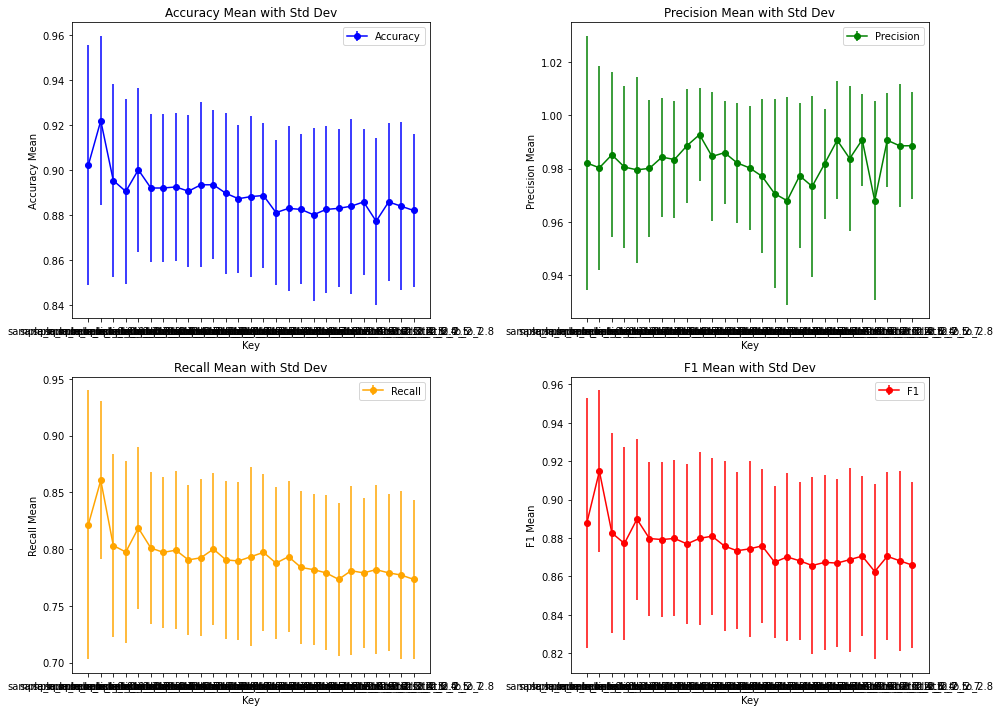

In [17]:
keys = list(classifier_dict.keys())

# Extracting metric values for plotting
acc_means = [classifier_dict[key]['acc_mean'] for key in keys]
acc_std_devs = [classifier_dict[key]['acc_std_dev'] for key in keys]

prec_means = [classifier_dict[key]['prec_mean'] for key in keys]
prec_std_devs = [classifier_dict[key]['prec_std_dev'] for key in keys]

recall_means = [classifier_dict[key]['recall_mean'] for key in keys]
recall_std_devs = [classifier_dict[key]['recall_std_dev'] for key in keys]

f1_means = [classifier_dict[key]['f1_mean'] for key in keys]
f1_std_devs = [classifier_dict[key]['f1_std_dev'] for key in keys]

# Plotting
plt.figure(figsize=(14, 10))

# Accuracy Mean with Std Dev
plt.subplot(2, 2, 1)
plt.errorbar(keys, acc_means, yerr=acc_std_devs, fmt='-o', color='blue', label='Accuracy')
plt.title('Accuracy Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Accuracy Mean')
plt.legend()

# Precision Mean with Std Dev
plt.subplot(2, 2, 2)
plt.errorbar(keys, prec_means, yerr=prec_std_devs, fmt='-o', color='green', label='Precision')
plt.title('Precision Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Precision Mean')
plt.legend()

# Recall Mean with Std Dev
plt.subplot(2, 2, 3)
plt.errorbar(keys, recall_means, yerr=recall_std_devs, fmt='-o', color='orange', label='Recall')
plt.title('Recall Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Recall Mean')
plt.legend()

# F1 Mean with Std Dev
plt.subplot(2, 2, 4)
plt.errorbar(keys, f1_means, yerr=f1_std_devs, fmt='-o', color='red', label='F1')
plt.title('F1 Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('F1 Mean')
plt.legend()

plt.tight_layout()
plt.show()